# StarStudio_example.ipynb

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from abg_python.galaxy.gal_utils import Galaxy
from abg_python.all_utils import filterDictionary

from firestudio.studios.star_studio import StarStudio
matplotlib.rcParams['figure.dpi'] = 150

Create an abg_python$^\mathrm{TM}$ Galaxy instance

In [2]:
snapdir = "/scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/output"
snapnum = 600 
galaxy = Galaxy(
    'm12i_res7100',
    snapdir,
    600,
    datadir='/scratch/04210/tg835099/data/metal_diffusion')

Couldn't find a metadata file... for
 Metadata object at /scratch/04210/tg835099/data/metal_diffusion/m12i_res7100/metadata/meta_Galaxy_600.hdf5


Locate the main halo, center our coordinates, and rotate to be face-on.

In [3]:
galaxy.extractMainHalo()

Using the saved sub-snapshots
Failed to open saved sub-snapshots <class 'OSError'>
Loading gas particles of m12i_res7100_md at 600
Loading star particles of m12i_res7100_md at 600
Loading dark matter particles of m12i_res7100_md at 600
Reorienting...
Done.
Finished, output sub-snapshot to: /scratch/04210/tg835099/data/metal_diffusion/m12i_res7100/subsnaps/snapshot_600.hdf5
extract_halo_inner(m12i_res7100_md at 600,){'orient_stars': True} 99.72 s elapsed
Snapshot memory free


(14.389217379832706,
 True,
 -10.603726945070212,
 149.94232819552008,
 268.00569800569804,
 2.877843475966541)

#### Let's make a simple image of "starlight" with "gas attenuation" to get an idea of what to expect

In [4]:
disk_mask = np.ones(galaxy.sub_star_snap['Masses'].size)
xs,ys,zs = galaxy.sub_star_snap['Coordinates'].T

disk_mask = (np.abs(xs) < 20) & (np.abs(ys) < 20) & (np.abs(zs) < 20)

In [5]:
gas_disk_mask = np.ones(galaxy.sub_snap['Masses'].size)
gas_xs,gas_ys,gas_zs = galaxy.sub_snap['Coordinates'].T

gas_disk_mask = (np.abs(gas_xs) < 20) & (np.abs(gas_ys) < 20) & (np.abs(gas_zs) < 20)

In [6]:
from matplotlib.colors import LinearSegmentedColormap
segments = np.zeros((100,4))
segments[:,-1] = np.linspace(0,1,100)
gas_cmap = LinearSegmentedColormap.from_list('black_alpha_gradient',segments)

13344453.920410156
1297175.79296875


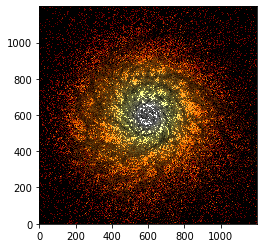

In [9]:
from matplotlib.colors import LogNorm
h_m,xedges,yedges = np.histogram2d(
    xs[disk_mask],
    ys[disk_mask],
    bins=1200,
    weights=galaxy.sub_star_snap['Masses'][disk_mask]*1e10)
print(h_m.max())

dA = np.diff(xedges)[0]
dA*=dA

plt.imshow((h_m.T+1e-12)/dA,norm=LogNorm(1e6,1e9),origin='lower',cmap='afmhot')
plt.gca().set_aspect(1)

from matplotlib.colors import LogNorm
h_m,xedges,yedges = np.histogram2d(
    gas_xs[gas_disk_mask],
    gas_ys[gas_disk_mask],
    bins=1200,
    weights=galaxy.sub_snap['Masses'][gas_disk_mask]*1e10)
print(h_m.max())

dA = np.diff(xedges)[0]
dA*=dA

plt.imshow((h_m.T)/dA,norm=LogNorm(1e5,1e9),origin='lower',cmap=gas_cmap)
plt.gca().set_aspect(1)
#plt.colorbar(label='M')

#### Now make a StarStudio instance

In [10]:
studio_datadir = os.path.join(os.path.dirname(galaxy.datadir),'firestudio')
print(studio_datadir)
my_starStudio = StarStudio(
    studio_datadir,
    galaxy.snapnum,
    galaxy.datadir_name,
    gas_snapdict=galaxy.sub_snap,
    star_snapdict=galaxy.sub_star_snap,
    )

/scratch/04210/tg835099/data/metal_diffusion/firestudio
setting maxden to default value of: None
setting dynrange to default value of: None
setting color_scheme_nasa to default value of: True
setting snapnum to user value of: 600
setting sim_name to user value of: m12i_res7100
setting frame_half_width to default value of: 15
setting frame_half_thickness to default value of: 15
setting frame_center to default value of: [0. 0. 0.]
setting theta to default value of: 0
setting phi to default value of: 0
setting psi to default value of: 0
setting aspect_ratio to default value of: 1
setting pixels to default value of: 1200
setting figure_label to default value of: 
setting scale_bar to default value of: True
setting scale_line_length to default value of: 5
setting noaxis to default value of: True
setting savefig to default value of: None
setting fontsize to default value of: 12
setting snapdir to default value of: None
Couldn't find a metadata file... for
 Metadata object at /scratch/04210/t

Rendering is very simple, the default arguments will do their best to create a realistic looking Hubble image.

cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!


/home1/04210/tg835099/python/firestudio/studios/star_studio.py:450: RuntimeWarning: divide by zero encountered in log10
  ## concatenate the luminosity maps and take the log of the non-empty ones


(43.28091080342381, 103.14494303545959)

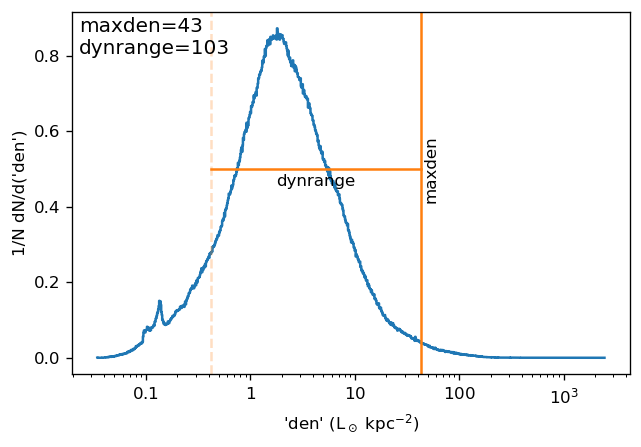

In [20]:
my_starStudio.predictParameters(ax=plt.gca())

cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
maxden ==  43.28091080342381  dynrange ==  103.14494303545959  minden ==  0.41961253290473505


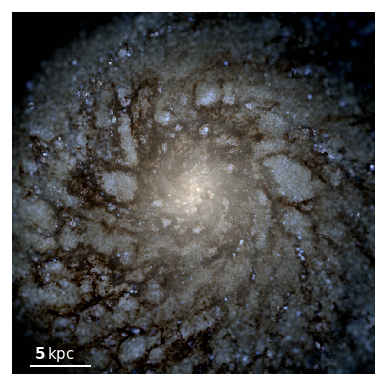

In [40]:
pixels = my_starStudio.render(plt.gca(),quick=False)
plt.gcf().set_dpi(120)

By "do their best" we mean that the maximum surface brightness and dynamic range will be, by default, chosen automatically based on the image. However, this may be undesirable if you'd like the colorscale to remain the same from all viewing angles or across simulations. Thus maxden and dynrange can be manually input. If they are not, they will default to the values from `predictParameters`. Note that `predictParameters` can choose `maxden` and `dynrange` algorithmically with whatever `left_percentile` and `right_percentile` the user desires (see [the documentation](https://github.com/agurvich/FIRE_studio/wiki/star_studio#starstudiopredictparameters) for more details). 

11502780 many star particles in volume
cache star_data compute_HSML(StarStudio instance,){} success!
Calculating L/M in Sloan u (BAND_ID=1,l=3551 A)
Calculating L/M in Sloan g (BAND_ID=2,l=4686 A)
Calculating L/M in Sloan r (BAND_ID=3,l=6165 A)
2010862 many gas particles in volume


(1246893289.7006187, 549.6684621419729)

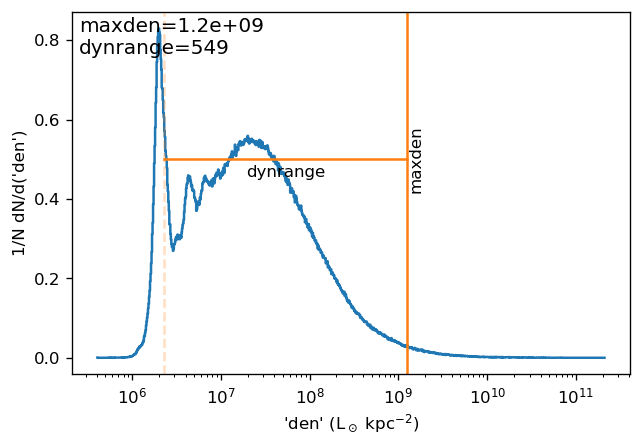

In [30]:
my_starStudio.predictParameters(ax=plt.gca(),quick=True)

`maxden` and `dynrange` can also be looped over to see what combination produces the most aesthetically pleasing result (see [the documentation](https://github.com/agurvich/FIRE_studio/wiki/star_studio#starstudioplotparametergrid) for details of controlling the loop). 

setting dynrange to user value of: 100.0
setting maxden to user value of: 0.01
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
maxden ==  0.01  dynrange ==  100.0  minden ==  0.0001


/home1/04210/tg835099/python/firestudio/studios/star_studio.py:325: RuntimeWarning: divide by zero encountered in log10
  rats = np.log10(all_bands.flatten())
/home1/04210/tg835099/python/firestudio/utils/stellar_utils/make_threeband_image.py:129: RuntimeWarning: divide by zero encountered in log10
  f_i = np.log10(i/minnorm) / np.log10(maxnorm/minnorm);
/home1/04210/tg835099/python/firestudio/utils/stellar_utils/make_threeband_image.py:137: RuntimeWarning: divide by zero encountered in log
  r = np.log(r/minnorm) / np.log(maxnorm/minnorm);
/home1/04210/tg835099/python/firestudio/utils/stellar_utils/make_threeband_image.py:138: RuntimeWarning: divide by zero encountered in log
  g = np.log(g/minnorm) / np.log(maxnorm/minnorm);
/home1/04210/tg835099/python/firestudio/utils/stellar_utils/make_threeband_image.py:139: RuntimeWarning: divide by zero encountered in log
  b = np.log(b/minnorm) / np.log(maxnorm/minnorm);


setting dynrange to user value of: 100.0
setting maxden to user value of: 0.0031622776601683794
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
maxden ==  0.0031622776601683794  dynrange ==  100.0  minden ==  3.1622776601683795e-05
setting dynrange to user value of: 100.0
setting maxden to user value of: 0.001
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
maxden ==  0.001  dynrange ==  100.0  minden ==  1e-05
setting dynrange to user value of: 100.0
setting maxden to us

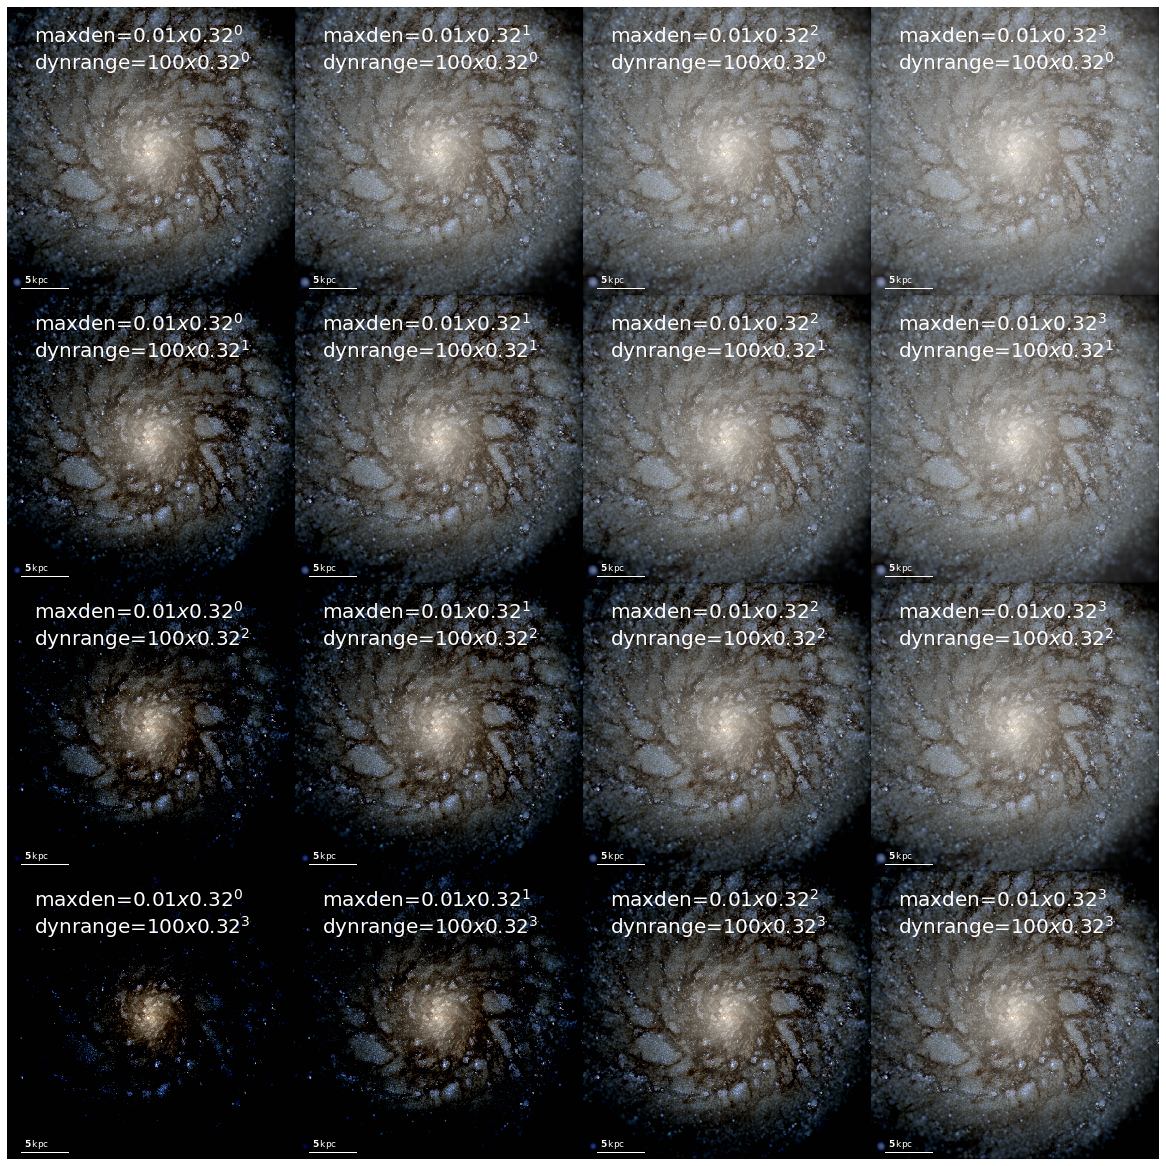

In [17]:
fig,axs = my_starStudio.plotParameterGrid()
fig.savefig('../src/hubble_grid.pdf',pad_inches=0,bbox_inches='tight')

And last but not least, if you're more of an SDSS fan, you can use their colorscheme by setting `use_colorscheme_nasa=False`. 

setting dynrange to user value of: 100.0
setting maxden to user value of: 0.01
setting color_scheme_nasa to user value of: False
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
maxden ==  0.01  dynrange ==  100.0  minden ==  0.0001


/home1/04210/tg835099/python/firestudio/studios/star_studio.py:325: RuntimeWarning: divide by zero encountered in log10
  rats = np.log10(all_bands.flatten())
/home1/04210/tg835099/python/firestudio/utils/stellar_utils/make_threeband_image.py:129: RuntimeWarning: divide by zero encountered in log10
  f_i = np.log10(i/minnorm) / np.log10(maxnorm/minnorm);
/home1/04210/tg835099/python/firestudio/utils/stellar_utils/make_threeband_image.py:135: RuntimeWarning: divide by zero encountered in true_divide
  wt=f_i/i; r*=wt; g*=wt; b*=wt;
/home1/04210/tg835099/python/firestudio/utils/stellar_utils/make_threeband_image.py:135: RuntimeWarning: invalid value encountered in true_divide
  wt=f_i/i; r*=wt; g*=wt; b*=wt;


setting dynrange to user value of: 100.0
setting maxden to user value of: 0.0031622776601683794
setting color_scheme_nasa to user value of: False
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
maxden ==  0.0031622776601683794  dynrange ==  100.0  minden ==  3.1622776601683795e-05
setting dynrange to user value of: 100.0
setting maxden to user value of: 0.001
setting color_scheme_nasa to user value of: False
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
cache npix1200_width30.00kpc_depth15.00kpc_x0.00_y0.00_z0.00_theta0.00_phi0.00_psi0.00_aspect1.00 compute_mockHubbleImage(StarStudio instance,){} success!
maxden ==  0.001

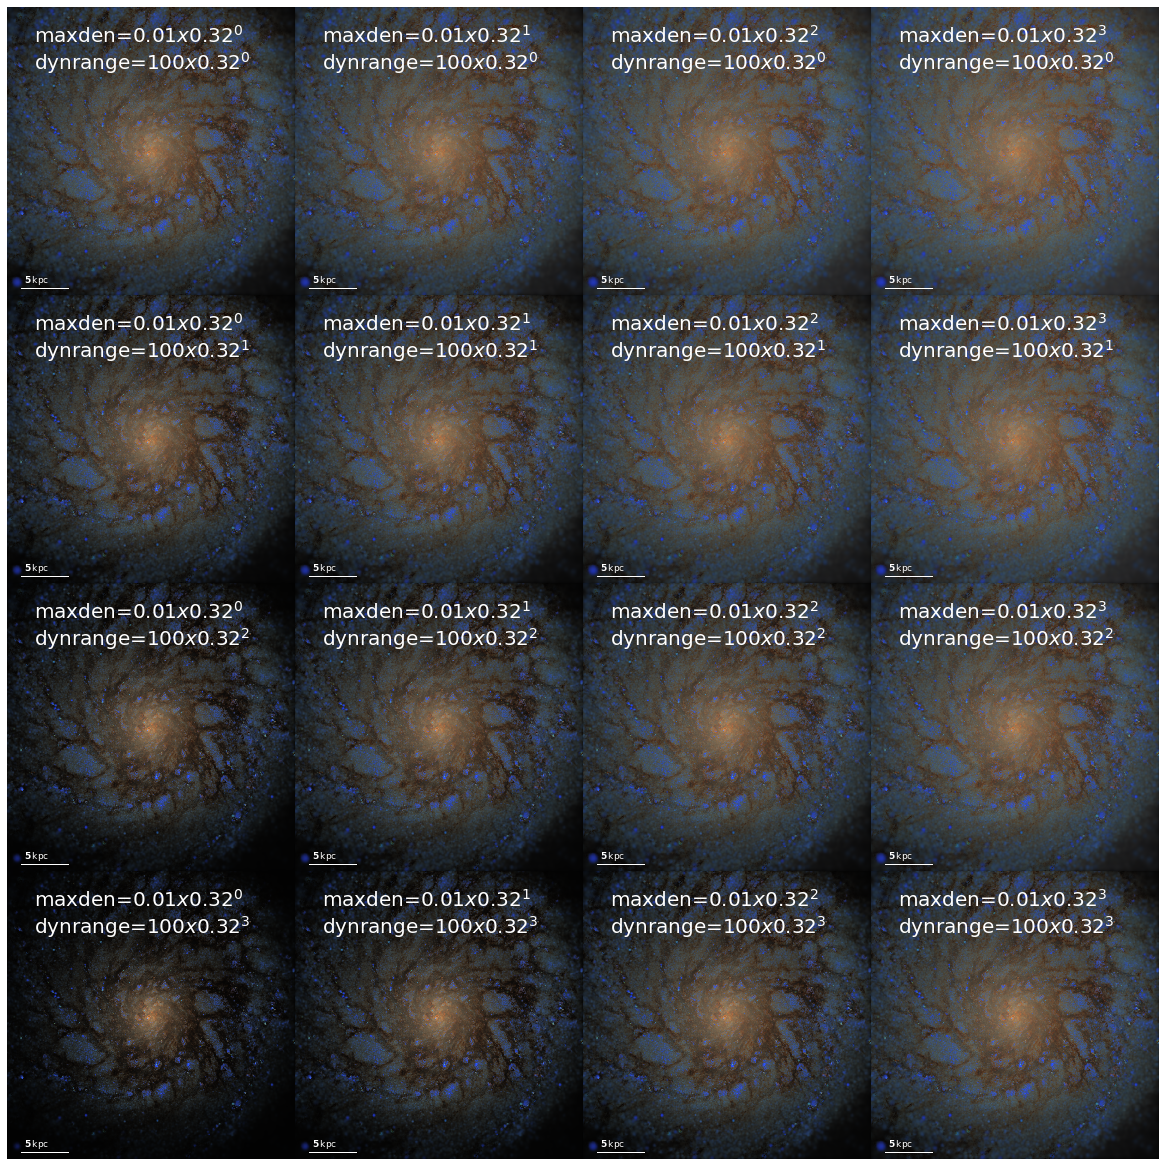

In [18]:
fig,axs = my_starStudio.plotParameterGrid(color_scheme_nasa=False)
fig.savefig('../src/sdss_grid.pdf',pad_inches=0,bbox_inches='tight')